In [13]:
# 필요한 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.combine import SMOTETomek  # 혼합 샘플링 기법 사용
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# BaseModel 클래스 정의 (임베딩 차원 및 모델 구조 간소화)
class BaseModel(nn.Module):
    def __init__(self, encoding_dim, cat_features, num_features, num_classes, cat_cardinalities):
        super(BaseModel, self).__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality+1, min(10, (cardinality + 1) // 2)) # other 처리하기 위한 임베딩
            for cardinality in cat_cardinalities
        ])
        embedding_output_dim = sum([embedding.embedding_dim for embedding in self.cat_embeddings])
        input_dim = embedding_output_dim + len(num_features)
        self.fc_cat = nn.Linear(input_dim, 64)
        self.encoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x_cat, x_num):
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        x_cat_embedded = torch.cat(embeddings, dim=1)
        x = torch.cat([x_cat_embedded, x_num], dim=1)
        x = self.fc_cat(x)
        encoded = self.encoder(x)
        out = self.classifier(encoded)
        return out

In [3]:
# 카디널리티 축소 함수 정의
def reduce_cardinality(data, column, threshold=10):
    value_counts = data[column].value_counts()
    categories_to_keep = value_counts[value_counts >= threshold].index
    data[column] = data[column].apply(lambda x: x if x in categories_to_keep else 'Other')
    return data


In [4]:
# 데이터 전처리 함수 정의
def encode_and_standardize_data(data, mode, label_encoders=None, scaler=None, min_values=None):
    if 'Is Fraud?' in data.columns:
        data = data.drop('Is Fraud?', axis=1)

    continuous_columns = [
        'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month', 'Per Capita Income - Zipcode',
        'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Year', 'Month', 'Day', 'Amount',
        'Year PIN last Changed'
    ]
    categorical_columns = ['Card Brand', 'Card Type', 'Expires', 'Acct Open Date', 'Error Message']

    # 'Error Message' 변수의 카디널리티 축소 또는 제거
    if mode == 'Train':
        data = reduce_cardinality(data, 'Error Message', threshold=10)
    else:
        data['Error Message'] = data['Error Message'].apply(lambda x: x if x in label_encoders['Error Message'].classes_ else 'Other')

    # 수치형 변수의 결측치는 평균으로 대체
    data[continuous_columns] = data[continuous_columns].fillna(data[continuous_columns].mean())

    # 범주형 변수의 결측치는 최빈값으로 대체
    data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

    # 레이블 인코더 초기화
    if mode == 'Train':
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            data[col] = data[col].astype(str)
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    else:
        # 범주형 변수 인코딩 (테스트 데이터의 새로운 값을 'Other'로 매핑)
        for col in categorical_columns:
            le = label_encoders[col]
            # 'Other'가 없는 경우 클래스 추가
            if 'Other' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'Other')
            # 테스트 데이터에 새로운 값은 'Other'로 매핑
            data[col] = data[col].apply(lambda s: s if s in le.classes_ else 'Other')
            # 인코딩
            data[col] = le.transform(data[col])

    # 추가 범주형 피처 처리
    # 'Has Chip'
    data['Has Chip'] = np.where(data['Has Chip'] == True, 1, 0)
    categorical_columns += ['Has Chip']

    # 연속형 피처에서 최소값 빼기
    if mode == 'Train':
        min_values = {}
        for col in ['Birth Year', 'Year PIN last Changed']:
            min_values[col] = data[col].min()
            data[col] = data[col] - min_values[col]
    else:
        for col in ['Birth Year', 'Year PIN last Changed']:
            data[col] = data[col] - min_values[col]

    # 스케일러 적용
    if mode == 'Train':
        scaler = StandardScaler()
        data[continuous_columns] = scaler.fit_transform(data[continuous_columns])
    else:
        data[continuous_columns] = scaler.transform(data[continuous_columns])



    if mode == 'Test':  # 테스트 데이터 전처리의 마지막 단계
        for i, col in enumerate(categorical_columns):
            if col == 'Has Chip':  # 'Has Chip'은 0/1로 변환되었으므로 스킵
                continue
            max_index = label_encoders[col].classes_.size - 1  # 학습 데이터 기준 최대 인덱스
            data[col] = data[col].apply(lambda x: min(x, max_index))


    # 범주형 피처의 카디널리티 계산
    if mode == 'Train':
        cat_cardinalities = [data[col].nunique() for col in categorical_columns]
    else:
        cat_cardinalities = None

    # 피처 분할
    cat_features = data[categorical_columns].astype(int)
    num_features = data[continuous_columns]

    if mode == 'Train':
        return cat_features, num_features, cat_cardinalities, label_encoders, scaler, min_values
    else:
        return cat_features, num_features

In [5]:
# 데이터 로드 및 전처리
train_data = pd.read_csv('data/train.csv')
y_train = train_data['Is Fraud?']
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)

x_cat_train, x_num_train, cat_cardinalities_train, label_encoders, scaler, min_values = encode_and_standardize_data(
    train_data, mode='Train'
)

x_resampled, y_resampled = pd.concat([x_cat_train,x_num_train],axis=1), y_train_encoded

x_cat_train_resampled = x_resampled[x_cat_train.columns]
x_num_train_resampled = x_resampled[x_num_train.columns]
y_train_resampled = y_resampled

# Tensor로 변환
x_cat_train_tensor = torch.tensor(x_cat_train_resampled.values, dtype=torch.long)
x_num_train_tensor = torch.tensor(x_num_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)

In [6]:
# 테스트 데이터 전처리
test_data = pd.read_csv('data/test.csv')
x_cat_test, x_num_test = encode_and_standardize_data(
    test_data, mode='Test', label_encoders=label_encoders, scaler=scaler, min_values=min_values
)
x_cat_test_tensor = torch.tensor(x_cat_test.values, dtype=torch.long)
x_num_test_tensor = torch.tensor(x_num_test.values, dtype=torch.float32)

In [7]:
# 데이터셋 분할
X = pd.concat([x_cat_train_resampled, x_num_train_resampled], axis=1)
y = y_train_resampled

X_train, X_val, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42
)

x_cat_train_split = torch.tensor(X_train[x_cat_train.columns].values, dtype=torch.long)
x_num_train_split = torch.tensor(X_train[x_num_train.columns].values, dtype=torch.float32)

x_cat_val_split = torch.tensor(X_val[x_cat_train.columns].values, dtype=torch.long)
x_num_val_split = torch.tensor(X_val[x_num_train.columns].values, dtype=torch.float32)

y_train_split = torch.tensor(y_train_split, dtype=torch.long)
y_val_split = torch.tensor(y_val_split, dtype=torch.long)

In [8]:
# 데이터셋 정의
train_dataset = torch.utils.data.TensorDataset(x_cat_train_split, x_num_train_split, y_train_split)
val_dataset = torch.utils.data.TensorDataset(x_cat_val_split, x_num_val_split, y_val_split)

# 데이터로더 정의 (배치 크기 증가)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

In [9]:
# 모델 인스턴스 생성
model = BaseModel(
    encoding_dim=32,
    cat_features=x_cat_train.columns,
    num_features=x_num_train.columns,
    num_classes=len(le_target.classes_),
    cat_cardinalities=cat_cardinalities_train
)

# Loss Function, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 모델 학습 함수 정의
def train_model(model, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_cat_batch, x_num_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_cat_batch, x_num_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

        # 검증 루프
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x_cat_batch, x_num_batch, y_batch in val_loader:
                outputs = model(x_cat_batch, x_num_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [11]:
def extract_features(model, x_cat, x_num):
    model.eval()
    with torch.no_grad():
        # 임베딩 레이어 적용
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
        x_cat_embedded = torch.cat(embeddings, dim=1)
        x = torch.cat([x_cat_embedded, x_num], dim=1)
        x = model.fc_cat(x)
        # 인코더를 통과하여 특징 벡터 추출
        features = model.encoder(x)
    return features

In [12]:
# 학습 실행
train_model(model, train_loader, val_loader, num_epochs=20)

# 테스트 데이터에 대한 예측
model.eval()
with torch.no_grad():
    outputs = model(x_cat_test_tensor, x_num_test_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_labels = le_target.inverse_transform(predicted.cpu().numpy())

# 결과 출력
print(predicted_labels)


Epoch 1/20, Loss: 63.8480
Validation Loss: 12.2795, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 2/20, Loss: 46.0621
Validation Loss: 11.0285, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 3/20, Loss: 40.8614
Validation Loss: 10.2771, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 4/20, Loss: 36.7432
Validation Loss: 9.1563, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 5/20, Loss: 33.6342
Validation Loss: 8.4859, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 6/20, Loss: 31.1478
Validation Loss: 8.0531, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 7/20, Loss: 29.4132
Validation Loss: 7.6162, Accuracy: 0.9986, Precision: 0.9975, Recall: 0.9986, F1 Score: 0.9979
Epoch 8/20, Loss: 27.8130
Validation Loss: 7.7351, Accuracy: 0.9986, Precision: 0.9978, Recall: 0.9986, F1 Score: 0.9979
Epoch 9/20, Loss: 26.6496
Val

# t-sne&PCA

In [14]:
def extract_input_features(model, x_cat, x_num):
    model.eval()
    with torch.no_grad():
        # 카테고리형 변수 임베딩
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
        x_cat_embedded = torch.cat(embeddings, dim=1)
        # 임베딩된 카테고리형 변수와 수치형 변수 결합
        x_input = torch.cat([x_cat_embedded, x_num], dim=1)
    return x_input

# 인코더 출력 피처 추출 함수
def extract_encoded_features(model, x_cat, x_num):
    model.eval()
    with torch.no_grad():
        # 카테고리형 변수 임베딩
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
        x_cat_embedded = torch.cat(embeddings, dim=1)
        # 임베딩된 카테고리형 변수와 수치형 변수 결합
        x = torch.cat([x_cat_embedded, x_num], dim=1)
        x = model.fc_cat(x)
        # 인코더 통과
        encoded_features = model.encoder(x)
    return encoded_features

# 데이터 전처리: 표준화 (PCA의 경우 일반적으로 표준화가 권장됩니다)
def preprocess_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# 시각화 함수
def visualize(data_tsne, data_pca, labels, title_suffix=''):
    plt.figure(figsize=(20, 8))

    # t-SNE 시각화
    plt.subplot(1, 2, 1)
    fraud_indices = labels == 1
    normal_indices = labels == 0

    plt.scatter(data_tsne[normal_indices, 0], data_tsne[normal_indices, 1],
                label='Normal', alpha=0.5, s=10)
    plt.scatter(data_tsne[fraud_indices, 0], data_tsne[fraud_indices, 1],
                label='Fraud', alpha=0.5, s=10, c='red')

    plt.legend()
    plt.title(f't-SNE {title_suffix}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # PCA 시각화
    plt.subplot(1, 2, 2)
    plt.scatter(data_pca[normal_indices, 0], data_pca[normal_indices, 1],
                label='Normal', alpha=0.5, s=10)
    plt.scatter(data_pca[fraud_indices, 0], data_pca[fraud_indices, 1],
                label='Fraud', alpha=0.5, s=10, c='red')

    plt.legend()
    plt.title(f'PCA {title_suffix}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.tight_layout()
    plt.show()

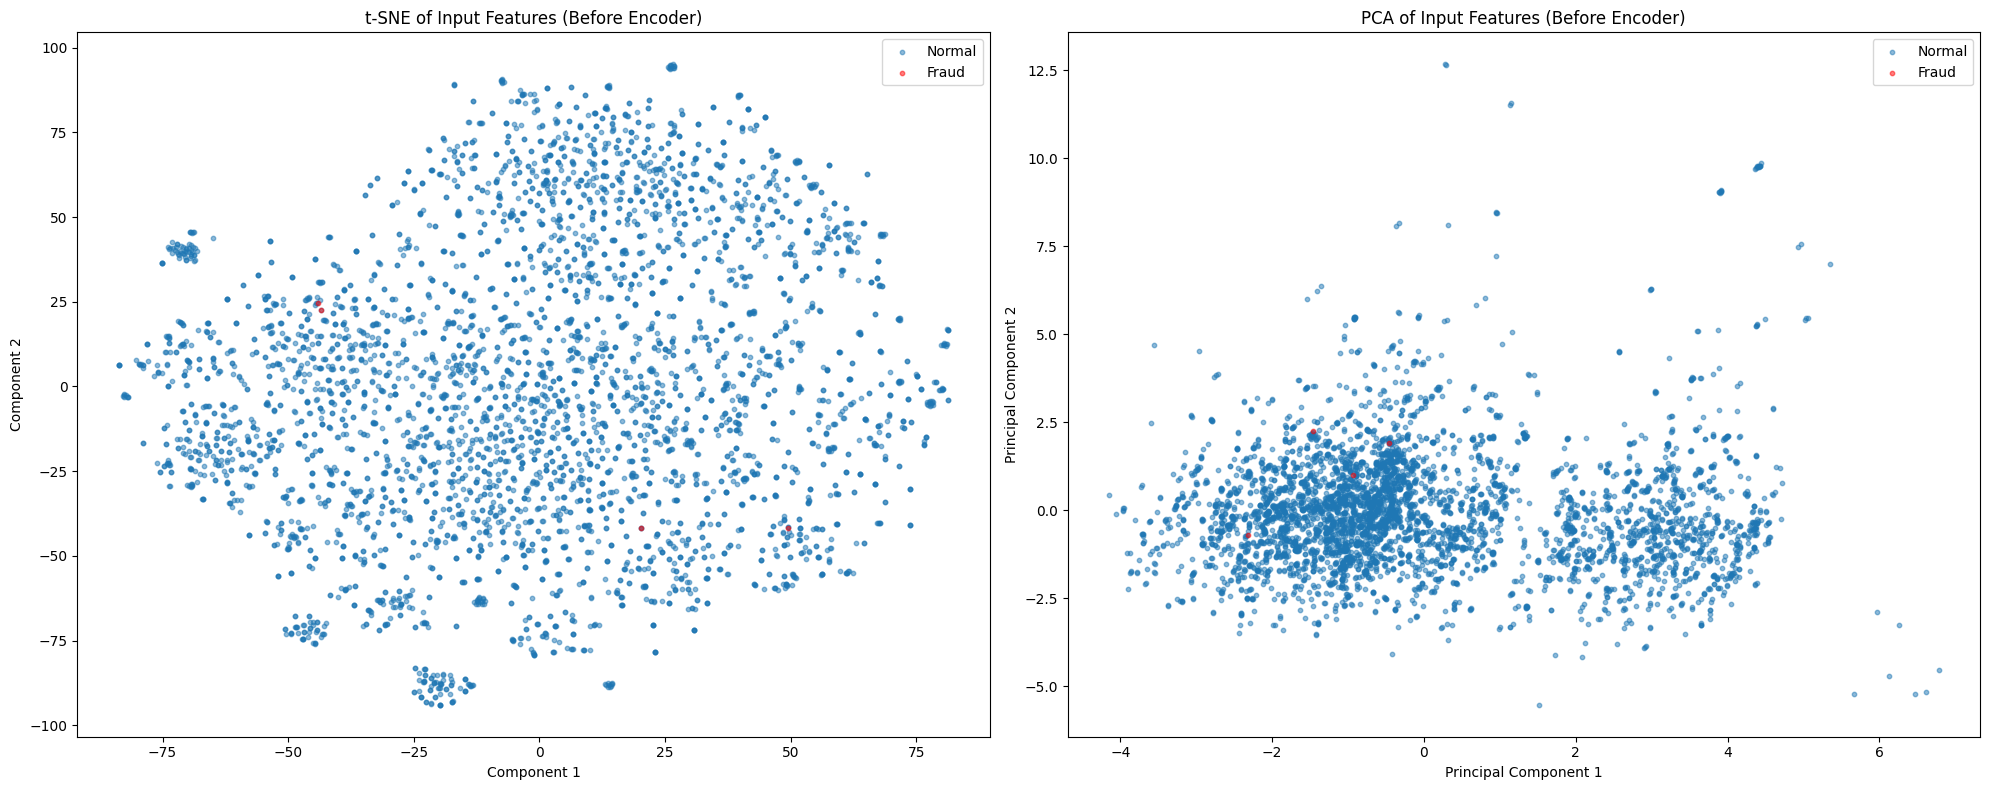

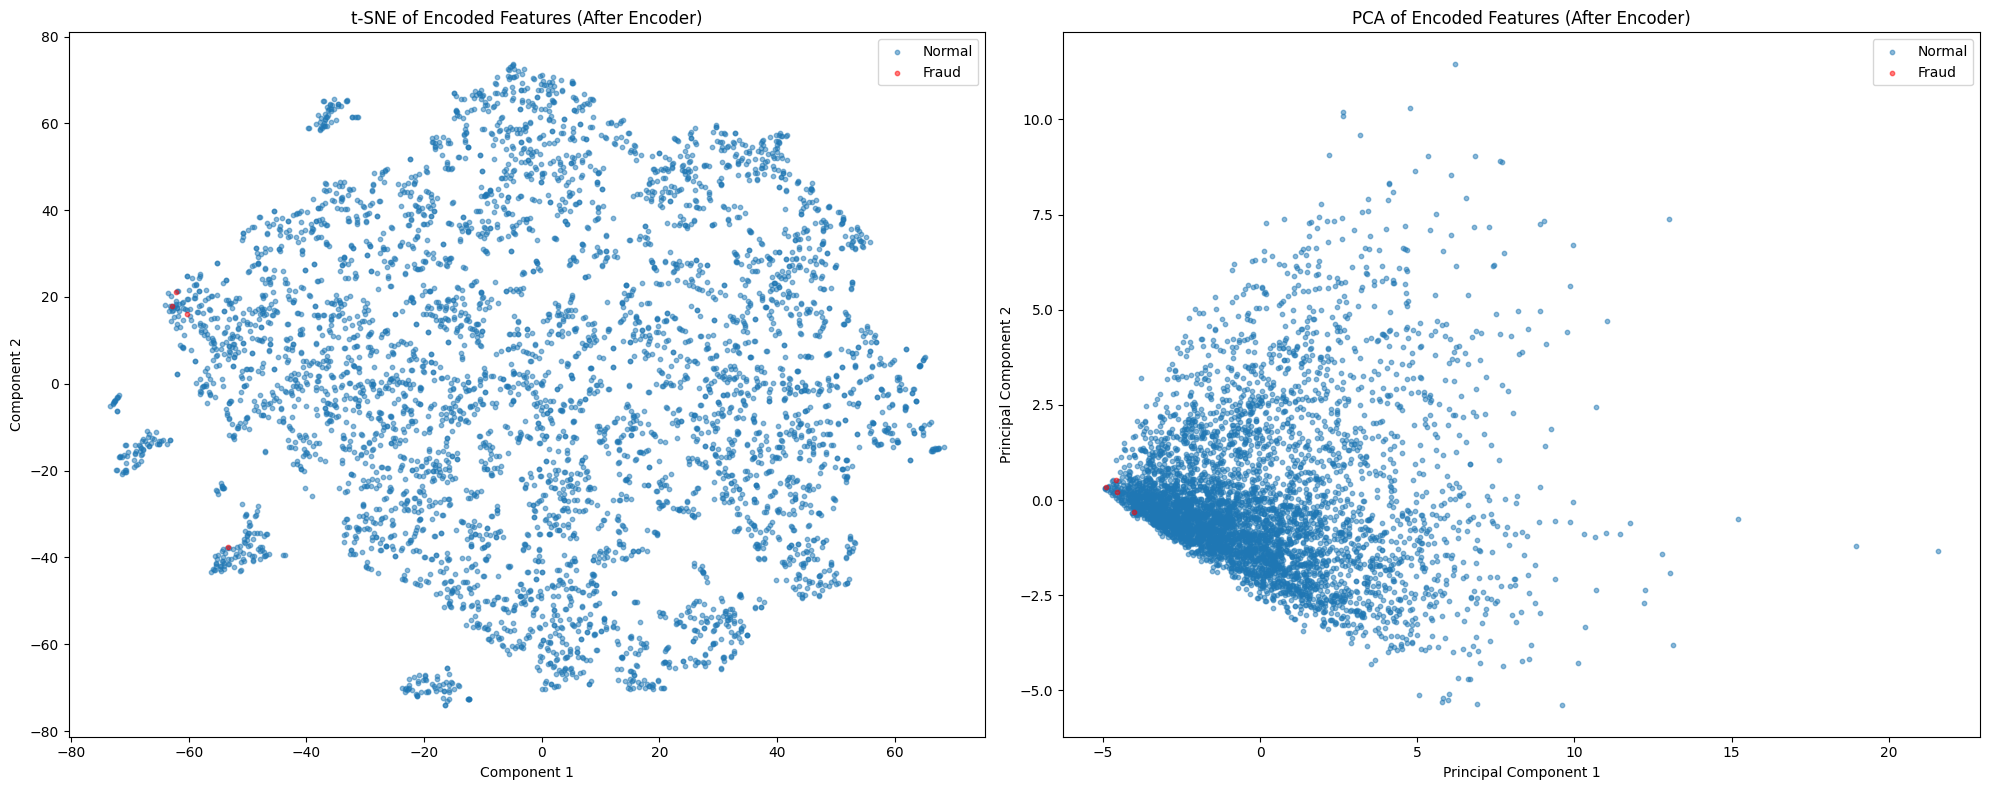

In [15]:
# 학습 데이터의 레이블 ('Is Fraud?')
y_train_labels = y_train_tensor.cpu().numpy()

# 인코더 입력 피처 추출
input_features = extract_input_features(model, x_cat_train_tensor, x_num_train_tensor)
input_features = input_features.cpu().numpy()

# 인코더 출력 피처 추출
encoded_features = extract_encoded_features(model, x_cat_train_tensor, x_num_train_tensor)
encoded_features = encoded_features.cpu().numpy()

# 데이터 샘플링 (예: 5000개 샘플 사용)
sample_size = 5000  # 원하는 샘플 크기 설정
indices = np.random.choice(len(input_features), size=sample_size, replace=False)
input_features_sample = input_features[indices]
encoded_features_sample = encoded_features[indices]
y_train_labels_sample = y_train_labels[indices]

# 전처리: PCA를 위한 표준화
input_features_sample_scaled = preprocess_features(input_features_sample)
encoded_features_sample_scaled = preprocess_features(encoded_features_sample)

# t-SNE 적용 (인코더 입력 피처)
tsne_input = TSNE(n_components=2, random_state=42)
input_features_tsne = tsne_input.fit_transform(input_features_sample_scaled)

# PCA 적용 (인코더 입력 피처)
pca_input = PCA(n_components=2, random_state=42)
input_features_pca = pca_input.fit_transform(input_features_sample_scaled)

# 시각화 (인코더 입력 피처)
visualize(input_features_tsne, input_features_pca, y_train_labels_sample, title_suffix='of Input Features (Before Encoder)')

# t-SNE 적용 (인코더 출력 피처)
tsne_encoded = TSNE(n_components=2, random_state=42)
encoded_features_tsne = tsne_encoded.fit_transform(encoded_features_sample_scaled)

# PCA 적용 (인코더 출력 피처)
pca_encoded = PCA(n_components=2, random_state=42)
encoded_features_pca = pca_encoded.fit_transform(encoded_features_sample_scaled)

# 시각화 (인코더 출력 피처)
visualize(encoded_features_tsne, encoded_features_pca, y_train_labels_sample, title_suffix='of Encoded Features (After Encoder)')